## Scraping Data from a Static News Website with BeautifulSoup

In [1]:
# Import libraries
import requests  # For making HTTP requests
from bs4 import BeautifulSoup  # For parsing HTML and XML documents
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

# Filter out warning messages to improve code readability
import warnings
warnings.filterwarnings('ignore')  # Ignore warning messages

As an example, let's attempt to perform content scraping from detikcom. Before doing so, it is necessary to visit the detikcom website to understand the URL structure that we intend to scrape. 

This involves inspecting the website to identify the specific URLs containing the news content we want to extract. This preliminary step allows us to familiarize ourselves with the website's layout and ensures that our scraping process is well-informed and targeted.

In [2]:
url_detik = 'https://www.detik.com/tag/anies-baswedan/?sortby=time&page=1'

# Making a get request 
response = requests.get(url_detik)

In [3]:
# print request status_code
response.status_code

200

The **response.status_code** provides a numerical indication of the HTTP status (200 for OK, 404 for Not Found). For additional information on HTTP status codes, refer to [this link](https://www.geeksforgeeks.org/http-status-codes-successful-responses/)

In [4]:
# Create a BeautifulSoup object to parse the HTML content of the response
soup = BeautifulSoup(response.content, "html.parser")

Next, we will proceed to extract the specific portions we desire. 

For instance, if our goal is to retrieve the title from each news content, we will target the elements within the HTML structure marked with the `<h>` tag and class `"title"` as illustrated in the image below. (note: you can inspect a website by using the keyboard shortcut `Ctrl+Shift+C`)

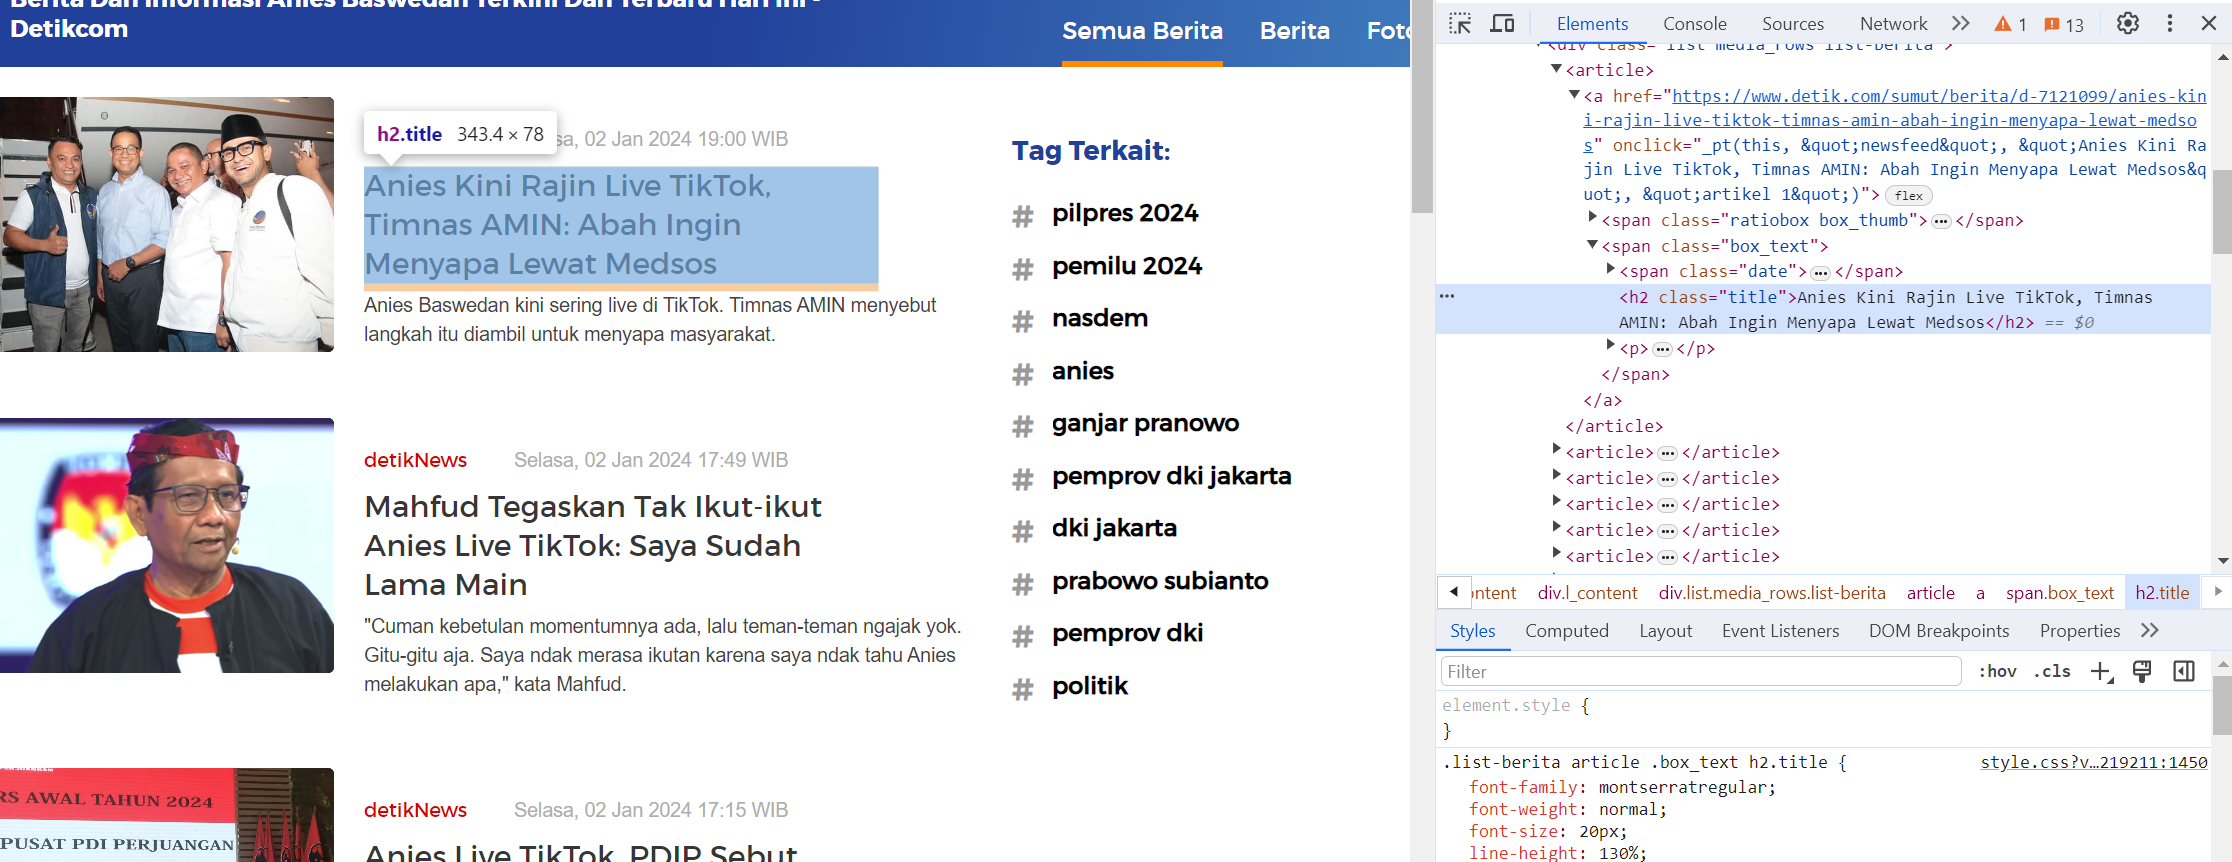

In [5]:
# Find all HTML elements with the tag <h2> and class 'title' within the parsed HTML content
tag_for_titles = soup.find_all('h2', 'title')
tag_for_titles

[<h2 class="title">Klaim Jubir AMIN Caleg Parpol Koalisi Sibuk Cari Kursi Legislatif</h2>,
 <h2 class="title">Cak Imin Ingin Ikut Anies Coba Live di TikTok: Tunggu Waktu yang Cocok</h2>,
 <h2 class="title">Alasan Anies Baswedan Rajin Live TikTok hingga Dijuluki 'Abah'</h2>,
 <h2 class="title">Pembagian Rokok Bergambar Anies-Cak Imin Diduga Langgar Pidana Pemilu</h2>,
 <h2 class="title">Park Ahn Nice Trending di X, Ternyata Nama Korea Anies Baswedan</h2>,
 <h2 class="title">Anies Kini Rajin Live TikTok, Timnas AMIN: Abah Ingin Menyapa Lewat Medsos</h2>,
 <h2 class="title">Mahfud Tegaskan Tak Ikut-ikut Anies Live TikTok: Saya Sudah Lama Main</h2>,
 <h2 class="title">Anies Live TikTok, PDIP Sebut Ganjar-Mahfud Akan Rangkul Rakyat di Medsos</h2>,
 <h2 class="title">Anies Baswedan Besok Bakal Kunjungi 2 Daerah di Sumbar, Ini Agendanya</h2>,
 <h2 class="title">Timnas AMIN Realistis Pilpres 2 Putaran, Klaim Elektoral 3 Paslon Merata</h2>]

In [6]:
# Extract title text
titles = [i.text for i in tag_for_titles]
titles

['Klaim Jubir AMIN Caleg Parpol Koalisi Sibuk Cari Kursi Legislatif',
 'Cak Imin Ingin Ikut Anies Coba Live di TikTok: Tunggu Waktu yang Cocok',
 "Alasan Anies Baswedan Rajin Live TikTok hingga Dijuluki 'Abah'",
 'Pembagian Rokok Bergambar Anies-Cak Imin Diduga Langgar Pidana Pemilu',
 'Park Ahn Nice Trending di X, Ternyata Nama Korea Anies Baswedan',
 'Anies Kini Rajin Live TikTok, Timnas AMIN: Abah Ingin Menyapa Lewat Medsos',
 'Mahfud Tegaskan Tak Ikut-ikut Anies Live TikTok: Saya Sudah Lama Main',
 'Anies Live TikTok, PDIP Sebut Ganjar-Mahfud Akan Rangkul Rakyat di Medsos',
 'Anies Baswedan Besok Bakal Kunjungi 2 Daerah di Sumbar, Ini Agendanya',
 'Timnas AMIN Realistis Pilpres 2 Putaran, Klaim Elektoral 3 Paslon Merata']

#### Lexicon Based Sentiment Analysis

To make it more engaging, we can perform sentiment analysis using a lexicon-based approach. 

In this case, we will utilize TextBlob, a natural language processing library in Python.By utilizing TextBlob, there is no need for manual labeling or building a machine learning model from scratch. To gain a deeper understanding of how TextBlob works, please visit the following [link](https://pypi.org/project/textblob/)

In [7]:
from textblob import TextBlob

In [8]:
def textblob_score(text):
    """
    The `text_en.sentiment` method provides two values: polarity and subjectivity.
    - Polarity ranges from -1.0 to 1.0, indicating the sentiment's negativity to positivity.
    - Subjectivity ranges from 0.0 to 1.0, where 0.0 is very factual, and 1.0 is very opinion-based.
    In our case, we focus on the polarity score to understand the sentiment's direction.
    """
    blob_object = TextBlob(text) # get texblob object
    text_en = blob_object.translate(from_lang='id', to='en') # translate into english
    score = text_en.sentiment.polarity # extract polarity score
    return score

In [9]:
# TSample text
sample_text = 'TPN Bantah Mahfud Live TikTok Terinspirasi Anies'

textblob_score(sample_text)

0.13636363636363635

Now, let's delve deeper into scraping. We'll extract multiple pieces of information from each news content simultaneously

In [10]:
# Create function to scrape data and get the polarity score 
def scrape_news(start_date="2024-01-01", keyword="pilpres 2024"):
    start_date = pd.Timestamp(start_date)
    keyword_url = keyword.replace(' ','-')
    news = []
    
    # Initialize page number
    x = 1
    
    # Loop for scraping pages until the start_date is reached
    while True:
        # Construct the URL for the current page
        url_detik = f'https://www.detik.com/tag/{keyword_url}/?sortby=time&page={x}'
        print(f'scrape page:{x}')
        
        # Make a request to the URL and parse the content
        page = requests.get(url_detik)
        soup = BeautifulSoup(page.content, "html.parser")

        # Find all articles on the page
        articles = soup.find_all('article')
        for i in articles:
            # Extract date, URL, and title from the article
            date = i.find('span','date').text.split(',')[1].replace('Des','Dec')
            date = pd.to_datetime(date)
            url = i.find('a').get('href')
            title = i.find('h2','title').text
            # Calculate sentiment score using textblob_score function
            polarity = textblob_score(title)

            # Break the loop if the start_date is greater than the current article's date
            if start_date>date:
                break

            news.append({
                'keyword':keyword,
                'platform':'detikcom',
                'date':date,
                'url':url,
                'title':title,
                'score':polarity
            })
        # Break the main loop if the start_date is greater than the current article's date or current page is 20
        if (start_date>date) or (x==20):
            break

        x += 1 # Move to the next page
        
    return news

#### Presidential candidate 1

In [11]:
keyword = 'anies baswedan'
start = "2023-11-28" # This marks the beginning of the campaign period for the 2024 elections.
anies_news = scrape_news(start_date=start, keyword=keyword)

scrape page:1
scrape page:2
scrape page:3
scrape page:4
scrape page:5
scrape page:6
scrape page:7
scrape page:8
scrape page:9
scrape page:10
scrape page:11
scrape page:12
scrape page:13
scrape page:14
scrape page:15
scrape page:16
scrape page:17
scrape page:18
scrape page:19
scrape page:20


In [12]:
df_anies = pd.DataFrame(anies_news)

# print 5 first data of df_anies
df_anies.head()

,keyword,platform,date,url,title,score
0,anies baswedan,detikcom,2024-01-03 06:45:00,https://www.detik.com/sulsel/berita/d-7121425/...,Klaim Jubir AMIN Caleg Parpol Koalisi Sibuk Ca...,0.050000
1,anies baswedan,detikcom,2024-01-02 23:51:00,https://news.detik.com/berita/d-7121453/cak-im...,Cak Imin Ingin Ikut Anies Coba Live di TikTok:...,0.295455
2,anies baswedan,detikcom,2024-01-02 21:11:00,https://www.detik.com/jateng/berita/d-7121323/...,Alasan Anies Baswedan Rajin Live TikTok hingga...,0.136364
3,anies baswedan,detikcom,2024-01-02 19:53:00,https://www.detik.com/bali/berita/d-7121216/pe...,Pembagian Rokok Bergambar Anies-Cak Imin Didug...,-0.400000
4,anies baswedan,detikcom,2024-01-02 19:20:00,https://inet.detik.com/detiktv/d-7121198/park-...,"Park Ahn Nice Trending di X, Ternyata Nama Kor...",0.600000


#### Presidential candidate 2

In [13]:
keyword = 'prabowo subianto'
start = "2023-11-28"
prabowo_news = scrape_news(start_date=start, keyword=keyword)

scrape page:1
scrape page:2
scrape page:3
scrape page:4
scrape page:5
scrape page:6
scrape page:7
scrape page:8
scrape page:9
scrape page:10
scrape page:11
scrape page:12
scrape page:13
scrape page:14
scrape page:15
scrape page:16
scrape page:17
scrape page:18
scrape page:19
scrape page:20


#### Presidential candidate 3

In [14]:
keyword = 'ganjar pranowo'
start = "2023-11-28"
ganjar_news = scrape_news(start_date=start, keyword=keyword)

scrape page:1
scrape page:2
scrape page:3
scrape page:4
scrape page:5
scrape page:6
scrape page:7
scrape page:8
scrape page:9
scrape page:10
scrape page:11
scrape page:12
scrape page:13
scrape page:14
scrape page:15
scrape page:16
scrape page:17
scrape page:18
scrape page:19
scrape page:20


In [15]:
df_prabowo = pd.DataFrame(prabowo_news)
df_ganjar = pd.DataFrame(ganjar_news)

In [337]:
def content_info(df):
    # Make a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Extract keyword from the first row of the 'query' column
    keyword = df.loc[0, 'keyword']

    # Create new columns for positive, neutral, and negative sentiment based on polarity values
    df['pos'] = np.where(df['score'] > 0, 1, 0)
    df['neu'] = np.where(df['score'] == 0, 1, 0)
    df['neg'] = np.where(df['score'] < 0, 1, 0)

    # Display summary information about the dataset
    print(f'Total data for keyword "{keyword}": {df.shape[0]}')
    print(f'With {df["pos"].sum()} positive sentiments, {df["neu"].sum()} neutral, and {df["neg"].sum()} negative.')

**Now we can check the scraping result for each keyword from detikcom**

In [338]:
content_info(df_anies)

Total data for keyword "ganjar pranowo": 144
With 45 positive sentiments, 85 neutral, and 14 negative.


In [339]:
content_info(df_prabowo)

Total data for keyword "prabowo subianto": 49
With 16 positive sentiments, 28 neutral, and 5 negative.


In [340]:
content_info(df_ganjar)

Total data for keyword "ganjar pranowo": 145
With 46 positive sentiments, 85 neutral, and 14 negative.


### Make a vizualization

In [430]:
def data_viz(df):
    # Make a copy of the DataFrame to avoid modifying the original
    df = df.copy()

     # Create new columns for positive, neutral, and negative sentiment based on polarity values
    df['pos'] = np.where(df['score'] > 0, 1, 0)
    df['neu'] = np.where(df['score'] == 0, 1, 0)
    df['neg'] = np.where(df['score'] < 0, 1, 0)

    # Group by keyword and calculate the sum of positive, neutral, and negative sentiments
    tmp = df.groupby(['keyword'])[['pos', 'neu', 'neg']].sum().reset_index()

    # Prepare data for plotting
    key = list(tmp['keyword'].unique())
    df_map = tmp[['pos', 'neu', 'neg']].to_dict(orient='list')

    # Plotting
    x = np.arange(len(key))
    width = 0.25
    multiplier = 0

    fig, ax = plt.subplots()

    for attribute, measurement in df_map.items():
        offset = width * multiplier
        color = 'green' if attribute == 'pos' else 'lightblue' if attribute == 'neu' else 'red'
        rects = ax.bar(x + offset, measurement, width, label=attribute, color=color)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add labels, title, and legend
    ax.set_ylabel('Count')
    ax.set_title(f'Sentiment Analysis for News on Detikcom')
    ax.set_xticks(x + width * (multiplier - 1) / 2)
    ax.set_xticklabels(key, rotation=15, ha='center')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig('sentiment_{}.jpg'.format(df.loc[0,'platform']))

    plt.show()

In [431]:
# concat all dataframe
df_all = pd.concat([df_anies,df_prabowo,df_ganjar]).reset_index(drop=True)

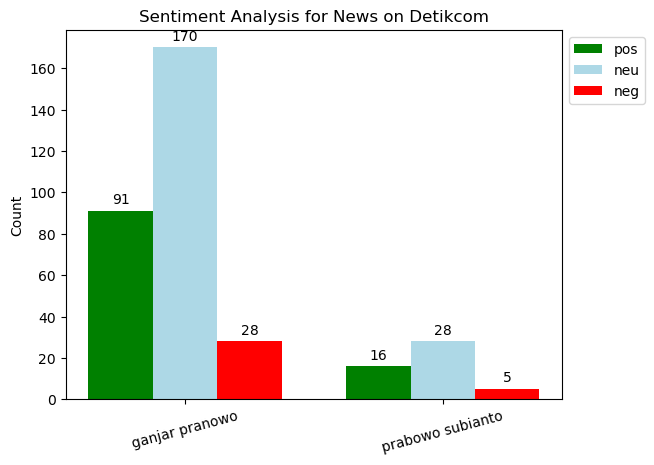

In [432]:
data_viz(df_all)

### WordCloud

In [381]:
# Start with loading all necessary libraries
from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

# Create stopword list
stopwords = {'di','ke','untuk','dari','dan','ini','itu','juga','saat'}

In [425]:
def wc(df, img_path):
    text = " ".join([i for i in df.title])
    print ("There are {} words from news title with keyword {}.".format(len(text),df.loc[0,'keyword']))
    
    mask = np.array(Image.open(img_path))
    # Generate a word cloud image
    wordcloud_por = WordCloud(stopwords=stopwords, background_color='white', max_words=5000, mask=mask).generate(text)

    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[7,7])
    plt.imshow(wordcloud_por.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.savefig(f'save_img/{df.loc[0,"keyword"]}.jpg')
    plt.show()

There are 9805 words from news title with keyword ganjar pranowo.


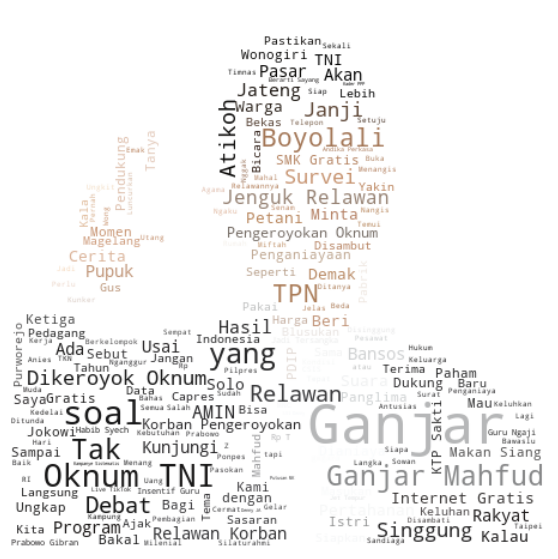

In [426]:
wc(df_anies, img_path='img/anies.jpg')

There are 3481 words from news title with keyword prabowo subianto.


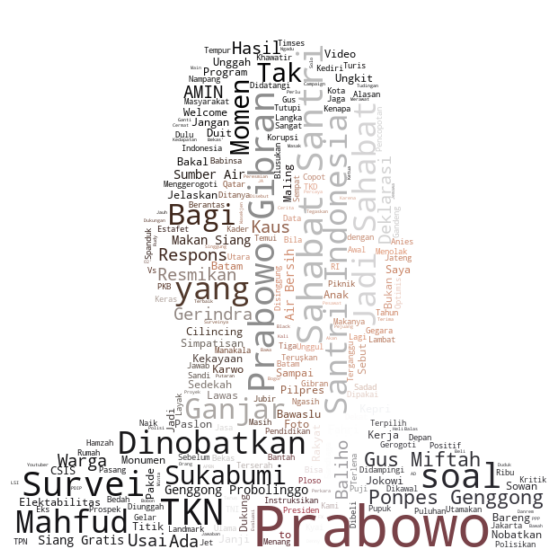

In [421]:
wc(df_prabowo, img_path='img/prabowo.jpg')

There are 9877 words from news title with keyword ganjar pranowo.


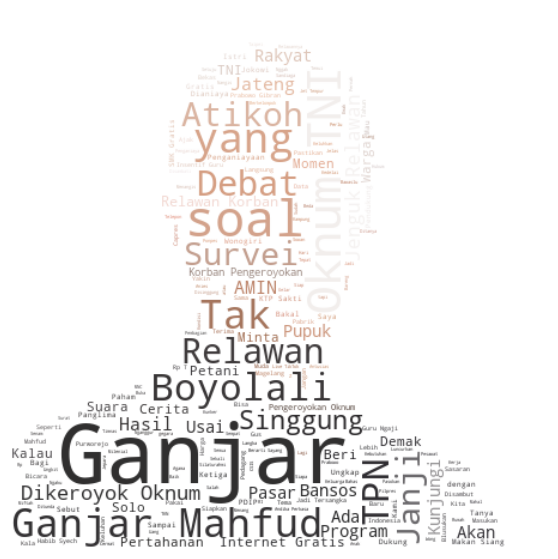

In [422]:
wc(df_ganjar, img_path='img/ganjar.jpg')